In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline

# Set the task and experiment type
task_name = 'maptask'
base_url = 'https://raw.github.com/NathanDuran/Maptask-Corpus/master/maptask_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
37        gru        1200  58.872602     0.237911
Best test accuracy in mean data:
  model_name  vocab_size   test_acc  test_acc_std  f1_micro  f1_micro_std
4     bi gru        1000  61.091954      0.457119  0.611405      0.004736


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,600,58.455547,0.283611,1000,61.091954,0.457119,0.611405,0.004736
1,bi lstm,1000,55.675458,0.545960,800,59.853448,0.295721,0.599240,0.003046
2,cnn,600,57.700522,0.205082,1600,59.327587,0.673426,0.594098,0.006662
3,dcnn,600,56.076386,0.321341,600,59.194685,0.484078,0.592759,0.004803
4,gru,1200,58.872602,0.237911,800,60.815372,0.828933,0.608617,0.007864
5,lstm,800,55.875112,0.381871,800,60.316810,0.468755,0.603910,0.004711
6,rcnn,800,58.163241,0.242606,800,60.284482,0.437835,0.603186,0.004474
7,text cnn,200,56.597583,0.332002,1400,59.301722,0.500288,0.593121,0.005173


Plot accuracy of each model per vocabulary size.

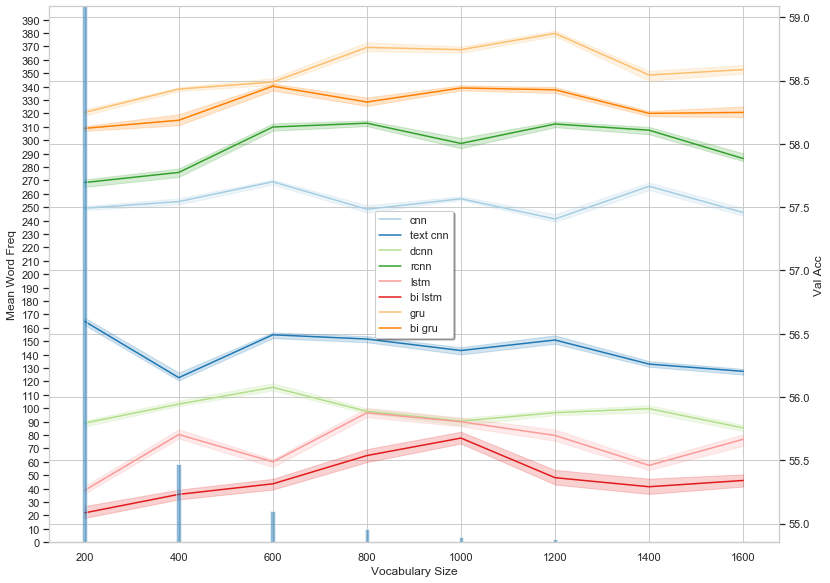

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
# vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:1600]
ind_start, ind_end = 0, 200
freq_dict = dict()
for i in range(8):
    freq_dict[ind_end] = word_freq.loc[ind_start:ind_end].mean() # Binning
    # freq_dict[ind_end] = word_freq.loc[0:ind_end].sum() # Cumulative summming
    ind_start += 200
    ind_end += 200
word_freq = pd.DataFrame.from_dict(freq_dict, orient='index')
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'vocab_size'}, inplace=True)

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, word_freq, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10, bar_axis_range=[0, 400], bar_width=10,
                          bar_y_label='Mean Word Freq', bar_alpha=0.5, bar_color='tab:blue', legend_loc='best', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
62     bi gru       1400  0.843372  0.048422
All models vocab_size have equal variance.
The following models do not have significant p-values when comparing vocab_size groups.
           sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
cnn      0.723056  7.0  0.103294  1.392605  0.221727  0.119247  0.033212
dcnn     0.713933  7.0  0.101990  1.403204  0.217392  0.120046  0.034078
bi lstm  2.304681  7.0  0.329240  1.151916  0.341192  0.100713  0.013118
bi gru   1.114897  7.0  0.159271  1.543857  0.166455  0.130508  0.045426


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.723056,7.0,0.103294,1.392605,0.221727,0.119247,0.033212
text cnn,1.679138,7.0,0.239877,2.805677,0.012192,0.214315,0.136440
dcnn,0.713933,7.0,0.101990,1.403204,0.217392,0.120046,0.034078
rcnn,2.374514,7.0,0.339216,3.132326,0.006056,0.233441,0.157241
lstm,2.847214,7.0,0.406745,2.437593,0.026717,0.191585,0.111734
bi lstm,2.304681,7.0,0.329240,1.151916,0.341192,0.100713,0.013118
gru,2.866167,7.0,0.409452,4.014275,0.000924,0.280719,0.208704
bi gru,1.114897,7.0,0.159271,1.543857,0.166455,0.130508,0.045426


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

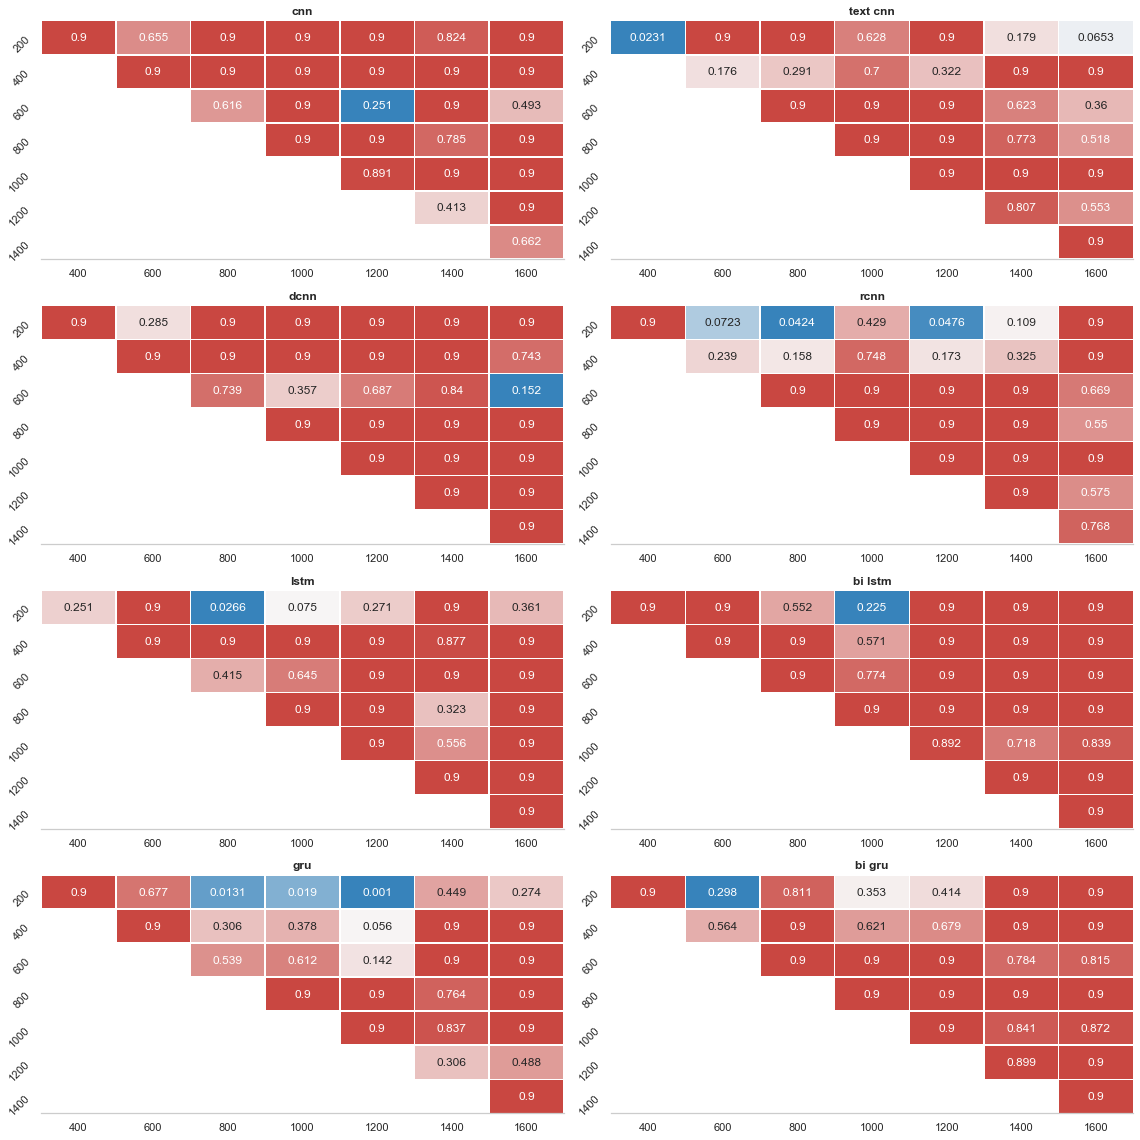

In [5]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [6]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
49        gru              30  58.677818     0.254389
Best test accuracy in mean data:
  model_name  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
2     bi gru              15  61.111349      0.634773  0.611441      0.006445


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,45,58.328786,0.299952,15,61.111349,0.634773,0.611441,0.006445
1,bi lstm,10,57.455415,0.256483,35,59.670257,0.811527,0.596995,0.008140
2,cnn,25,57.491556,0.263350,35,59.484913,0.514620,0.595366,0.005433
3,dcnn,25,56.141233,0.243263,20,59.277298,0.442291,0.593193,0.004385
4,gru,30,58.677818,0.254389,25,60.872844,0.415885,0.608798,0.004192
5,lstm,10,57.976544,0.257621,50,60.178161,0.658406,0.602353,0.006754
6,rcnn,25,58.132309,0.263509,25,60.214799,0.642516,0.602643,0.006468
7,text cnn,40,56.401361,0.331929,55,59.283763,0.314875,0.592940,0.003252


Plot accuracy of each model per sequence length.

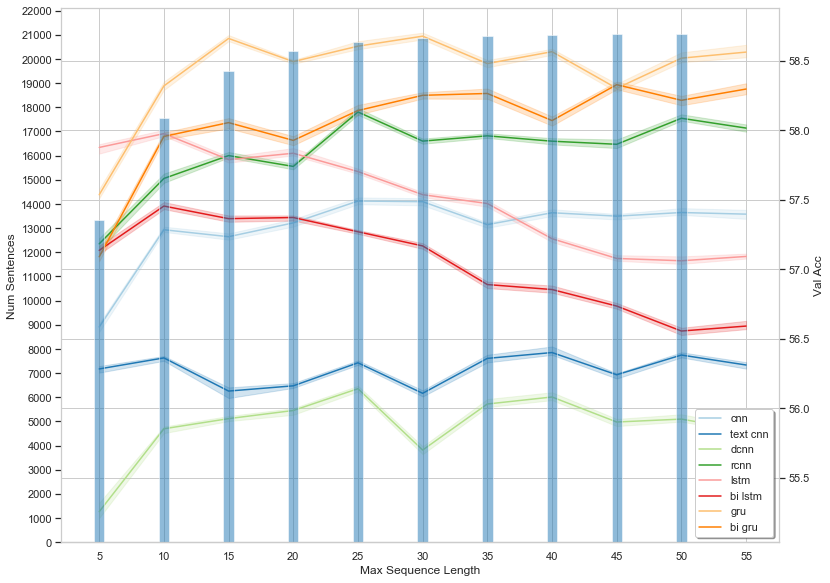

In [7]:
# TODO remove test data
# Get test and validation accuracy for each model
# seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])
#
# g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci=16,
#                       title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Bin into same values as experiment
ind_start, ind_end = 0, 5
freq_dict = dict()
for i in range(10):
    # freq_dict[ind_end] = sent_lengths.loc[ind_start:ind_end].sum()
    freq_dict[ind_end] = sent_lengths.loc[0:ind_end].sum() # Cumulative sum
    ind_start += 5
    ind_end += 5
sent_lengths = pd.DataFrame.from_dict(freq_dict, orient='index')
sent_lengths.reset_index(level=0, inplace=True)
sent_lengths.rename(columns={'index': 'max_seq_length', 0: 'Count'}, inplace=True)

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sent_lengths, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=1000, bar_axis_range=None, bar_width=0.8,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue', legend_loc='lower right', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [8]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
3         cnn             20  0.829943  0.033408
32       dcnn             55  0.821119  0.026144
80     bi gru             20  0.838532  0.042373
All models max_seq_length have equal variance.
The following models do not have significant p-values when comparing max_seq_length groups.
            sum_sq    df   mean_sq         F    PR(>F)    eta_sq  omega_sq
text cnn  1.110638  10.0  0.111064  1.708438  0.089189  0.147172  0.060507


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,6.276159,10.0,0.627616,8.511644,7.011400e-10,0.462297,0.405779
text cnn,1.110638,10.0,0.111064,1.708438,8.918859e-02,0.147172,0.060507
dcnn,5.700809,10.0,0.570081,6.206835,2.631651e-07,0.385354,0.321274
rcnn,6.842838,10.0,0.684284,8.807070,3.418396e-10,0.470788,0.415114
lstm,12.209577,10.0,1.220958,18.727790,8.659686e-19,0.654182,0.617096
bi lstm,10.517750,10.0,1.051775,16.408263,4.716802e-17,0.623692,0.583464
gru,10.225389,10.0,1.022539,10.653614,4.680829e-12,0.518333,0.467406
bi gru,12.069036,10.0,1.206904,9.635794,4.780115e-11,0.493238,0.439799


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

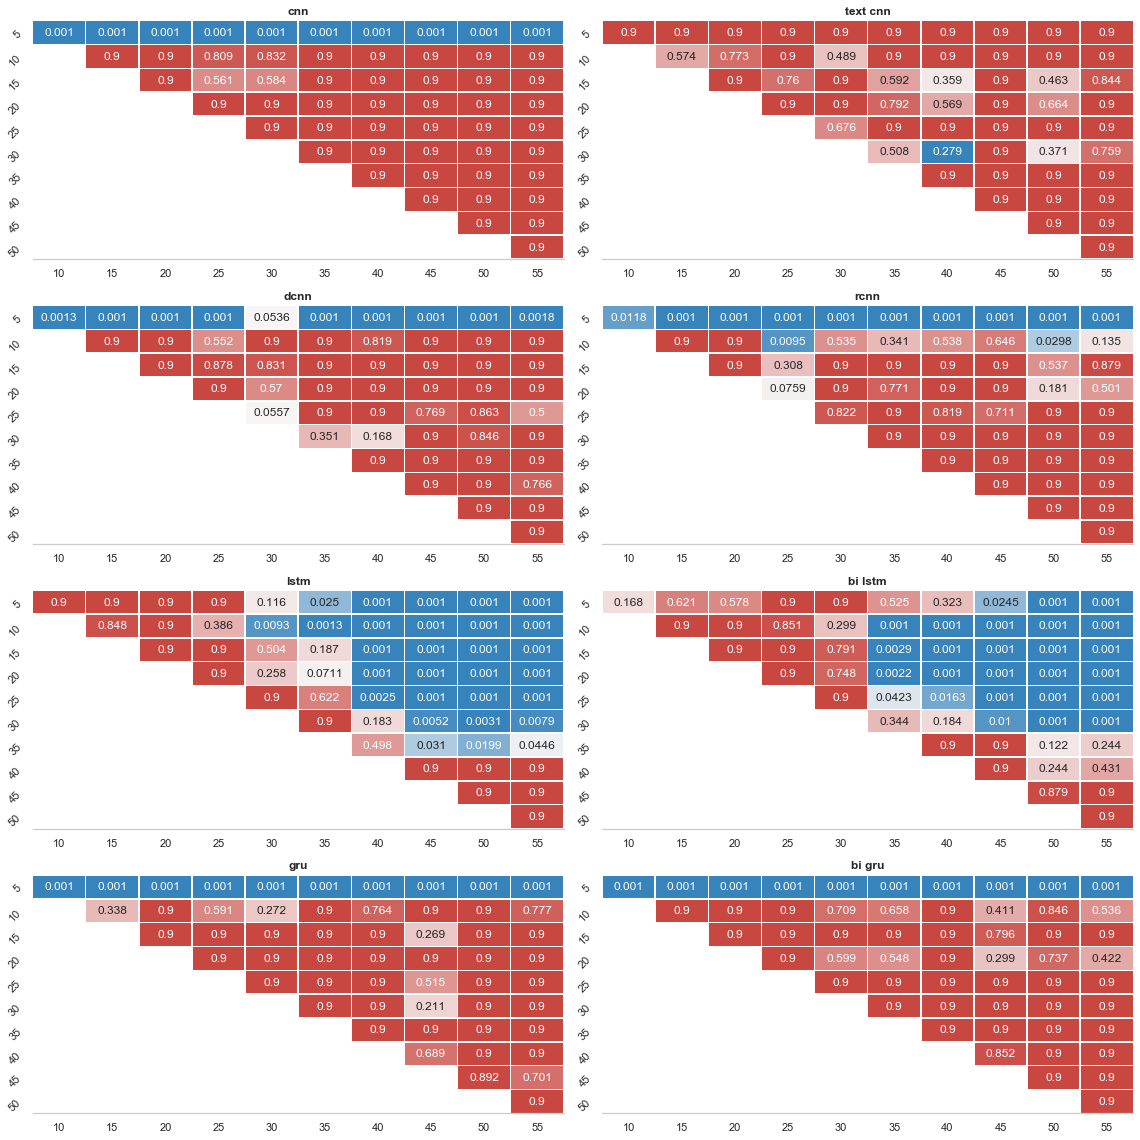

In [9]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))